In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


Model Performance Metrics with Forward Validation:
R-squared Score: 0.9931
Root Mean Square Error (RMSE): 86.0350
Mean Absolute Error: 40.3849
Mean Prediction Accuracy: 97.93%


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


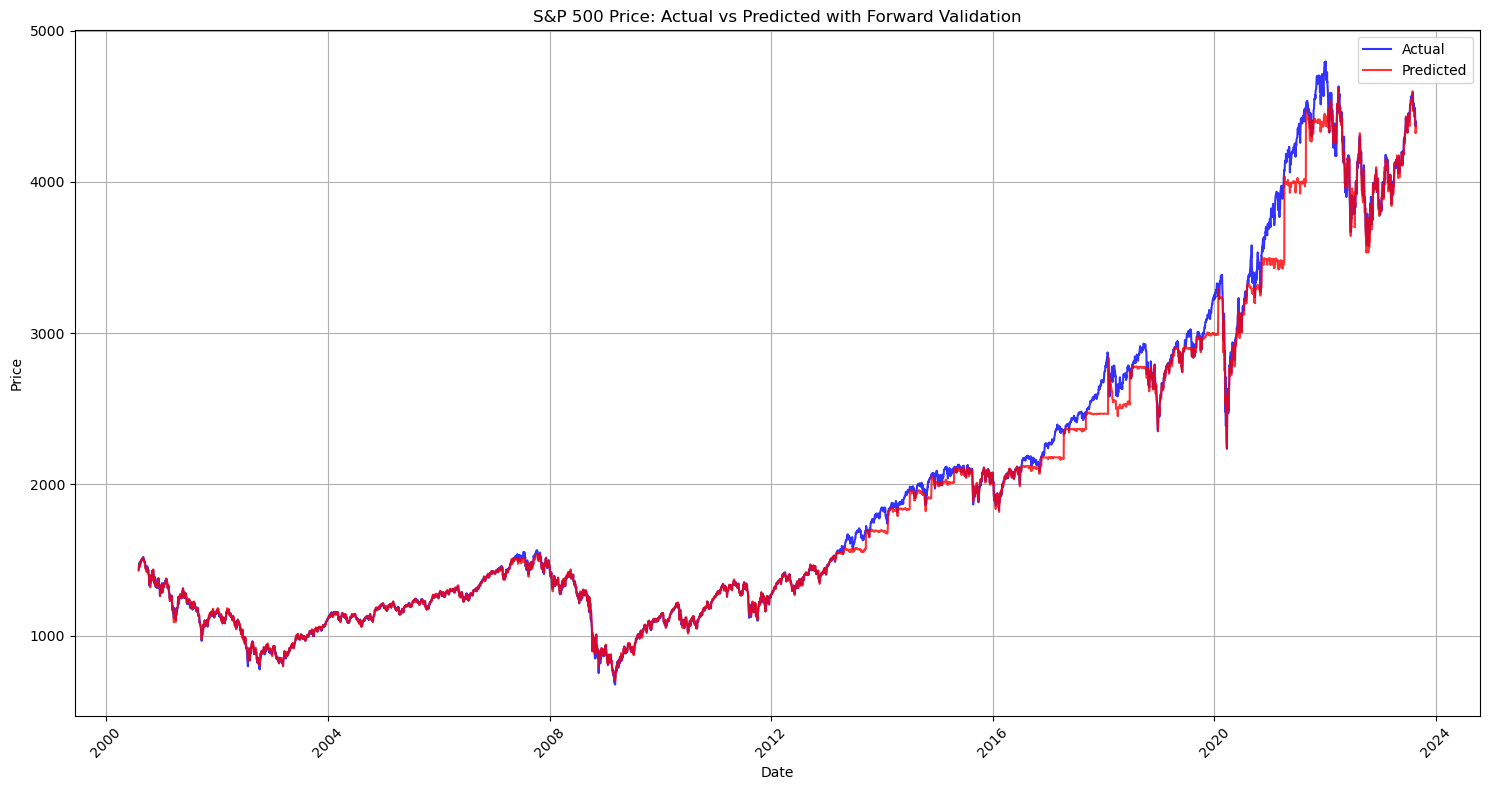

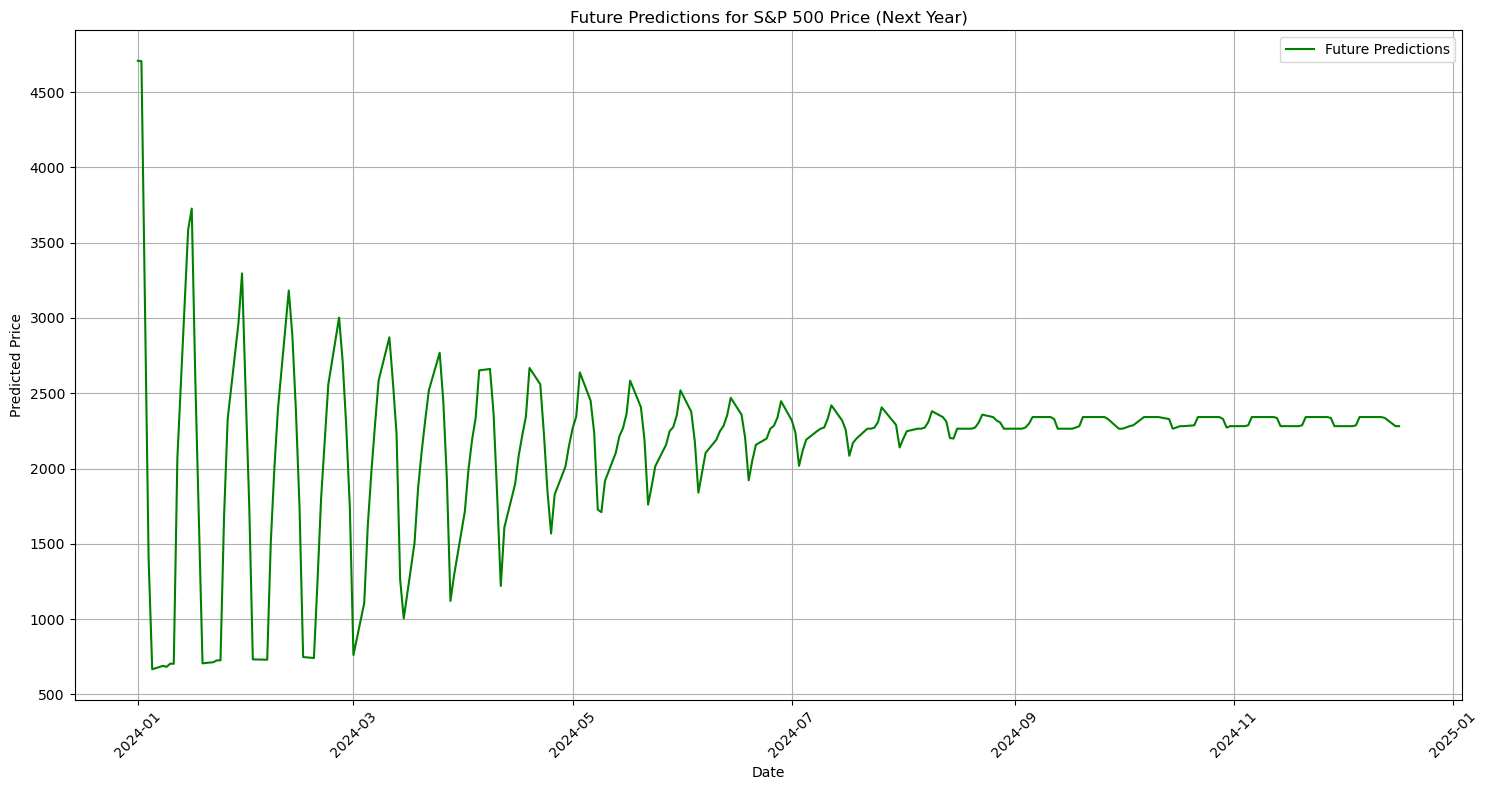

In [3]:
# Load the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv')  # Replace with your dataset file name
df['Date'] = pd.to_datetime(df['Date'])  # Ensure 'Date' is in datetime format
df.set_index('Date', inplace=True)  # Set 'Date' as the index

# Features and target
features = ['Open', 'High', 'Low', 'Volume', 'ATR', 'ADX', 'RSI', 'MACD', 'MACD_Signal', 'Volatility', 'Max_Drawdown']
target = 'Close'

X = df[features]
y = df[target]

# Normalize the features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Forward Validation Function
def forward_validation(df, features, target, initial_train_size, step_size, model_params):
    """
    Perform forward validation for time-series data.
    """
    predictions = []
    actuals = []
    dates = []
    n_splits = (len(df) - initial_train_size) // step_size

    for i in range(n_splits):
        train_start = 0
        train_end = initial_train_size + i * step_size
        test_start = train_end
        test_end = test_start + step_size

        X_train, y_train = df[features].iloc[train_start:train_end], df[target].iloc[train_start:train_end]
        X_test, y_test = df[features].iloc[test_start:test_end], df[target].iloc[test_start:test_end]
        dates.extend(df.index[test_start:test_end])

        # Train the model
        model = xgb.XGBRegressor(**model_params)
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)
        predictions.extend(preds)
        actuals.extend(y_test)

    return predictions, actuals, dates, model

# Define forward validation parameters
initial_train_size = 1000  # Initial training set size
step_size = 100  # Step size for moving train-test splits
model_params = {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 5, "random_state": 42}

# Perform forward validation
predictions, actuals, dates, model = forward_validation(df, features, target, initial_train_size, step_size, model_params)

# Calculate performance metrics
test_rmse = mean_squared_error(actuals, predictions, squared=False)
test_r2 = r2_score(actuals, predictions)
test_mae = mean_absolute_error(actuals, predictions)

mean_prediction_accuracy = 100 * (1 - test_mae / np.mean(actuals))

print("\nModel Performance Metrics with Forward Validation:")
print(f"R-squared Score: {test_r2:.4f}")
print(f"Root Mean Square Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Prediction Accuracy: {mean_prediction_accuracy:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(15, 8))
plt.plot(dates, actuals, label='Actual', color='blue', alpha=0.8)
plt.plot(dates, predictions, label='Predicted', color='red', alpha=0.8)
plt.title('S&P 500 Price: Actual vs Predicted with Forward Validation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predict the next year's closing prices
future_steps = 252  # Approx. number of business days in a year
future_predictions = []
current_features = X.iloc[-1].values  # Get the last row of features

for _ in range(future_steps):
    # Predict the next value
    next_pred = model.predict(current_features.reshape(1, -1))[0]
    future_predictions.append(next_pred)

    # Update lag features dynamically
    current_features = np.roll(current_features, -1)
    current_features[-1] = next_pred  # Replace the last feature with the predicted value

# Generate future dates
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')

# Plot future predictions
plt.figure(figsize=(15, 8))
plt.plot(future_dates, future_predictions, label='Future Predictions', color='green')
plt.title('Future Predictions for S&P 500 Price (Next Year)')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()